# 1. Import Dependencies

In [76]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import matplotlib.patheffects as PathEffects
import seaborn as sns

import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from importlib import reload
import neural_network_classes
reload(neural_network_classes)
from neural_network_classes import LSTM, DARNN, HARHN

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-11 00:00:00 999 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461
2022-07-04,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,27.0,5.405


# 4. Data Preprocessing

In [22]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
max_epochs = 250
target_name = 'gas price' # target variable name

timesteps = 4 # 10, lookback window
lstm_n_hidden = 64
lstm_n_layers = 2
darnn_n_enc_units = 64
darnn_n_dec_units = 64 # 64
harhn_n_enc_units = 64
harhn_n_dec_units = 64

## 4a. Incorporate Rolling Lookback Window

In [23]:
# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [24]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [26]:
prediction_horizon = 1
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [27]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

587 126 126


In [28]:
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [29]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [30]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [31]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [32]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

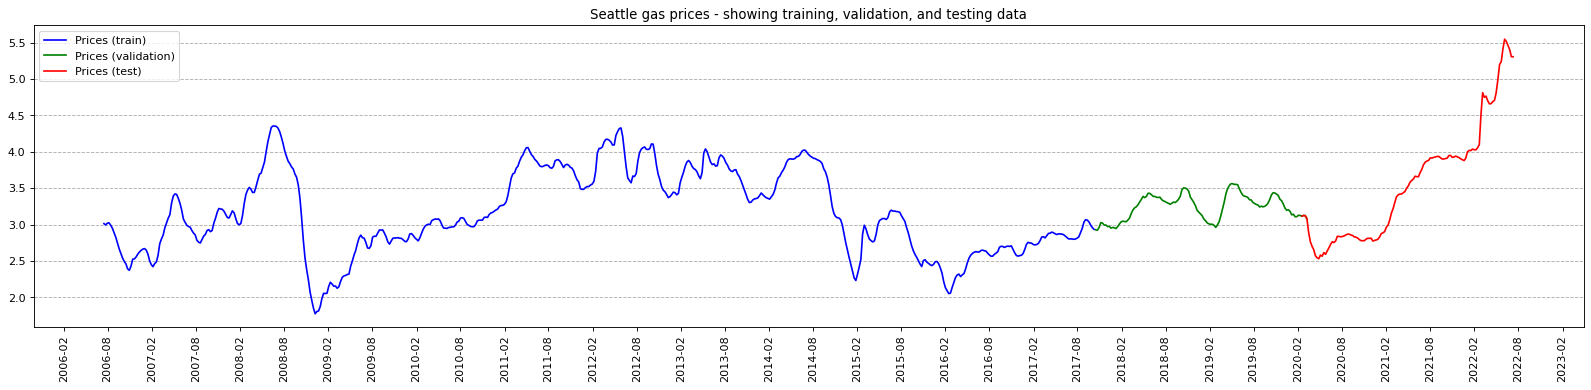

In [33]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [34]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [35]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 6. Modeling

In [36]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
def nn_train(model, model_name, epochs, data_train_loader, data_val_loader, opt, scheduler, target_scaler, plot=True):
    
    loss = nn.MSELoss()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True, path=f'{model_name}.pt') 

    for i in range(epochs):
        mse_train = 0

        for batch_x, batch_y_h, batch_y in data_train_loader :

            batch_x = batch_x.to(device)  
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            opt.zero_grad()
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                y_pred, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                y_pred, alpha, beta = model(batch_x, batch_y_h)
            elif model_name == 'harhn':
                y_pred = model(batch_x, batch_y_h)

            y_pred = y_pred.squeeze(1)        
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()

        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_h = batch_y_h.to(device)
                
                if model_name == 'lstm':
                    h, c = model.init_hidden_internal(batch_x.shape[0])
                    output, h, c = model(batch_x, batch_y_h, h, c)
                elif model_name == 'darnn':
                    output, alpha, beta = model(batch_x, batch_y_h)
                elif model_name == 'harhn':
                    output = model(batch_x, batch_y_h)

                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
                
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        # Learning rate scheduler
        scheduler.step(mse_val/len(X_val_t))
        lr = opt.param_groups[0]['lr']

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(mse_val/len(X_val_t), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
              "val: ", (mse_val/len(X_val_t))**0.5, 
              "LR: ", lr
             )
        if (plot == True) and (i % 10 == 0):
#             preds = preds*(target_train_max - target_train_min) + target_train_min
#             true = true*(target_train_max - target_train_min) + target_train_min
            preds = target_scaler.inverse_transform(preds)
            true = target_scaler.inverse_transform(true)
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(12, 6))
            plt.plot(preds, label='predicted')
            plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
            plt.legend(loc="upper left")
            plt.title(f'Validation Results for Epoch {i}')
            plt.show()
    return

In [74]:
def nn_eval(model, model_name, data_test_loader, target_scaler):
    
    with torch.no_grad():
        mse_val = 0
        loss = nn.MSELoss()
        preds = []
        true = []
        alphas = []
        betas = []
        for batch_x, batch_y_h, batch_y in data_test_loader:
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                output, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                output, alpha, beta = model(batch_x, batch_y_h)
                alphas.append(alpha.detach().cpu().numpy())
                betas.append(beta.detach().cpu().numpy())
            elif model_name == 'harhn':
                output = model(batch_x, batch_y_h)
                
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    if model_name == 'darnn':
        alphas = np.concatenate(alphas)
        betas = np.concatenate(betas)
    
    # De-normalize
    preds = target_scaler.inverse_transform(preds)
    true = target_scaler.inverse_transform(true)
    
    # Collect results
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    pcc, _ = PCC(true, preds)  
    err = true - preds
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(preds, label='preds')
    plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
    plt.legend(loc="upper left")
    plt.title(f'Test Results for {model_name.upper()} Model', fontsize=15)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Seattle Gas Price', fontsize=12)
    plt.show()
    
    # Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.regplot(ax=ax, x=true, y=preds)
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predictions', fontsize=12)
    ax.set_title(f'Test Prediction Correlation \n R2 = {r2:.3f} \n PCC = {pcc:.3f}', fontsize=15)
    ax.set_aspect('equal', 'box')
    
    # Error Histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(ax=ax, data=err, kde=True)
    ax.set_xlabel('Prediction Errors (U.S. $)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Model Testing Prediction Errors \n MSE = {mse:.3f} \n MAE = {mae:.3f}', fontsize=15)
        
    if model_name == 'darnn':
        alphas = alphas.mean(axis=0)
        betas = betas.mean(axis=0).squeeze()[::-1]

        attn = np.zeros([len(alphas), len(betas)])
        for i in range(len(alphas)):
            for j in range(len(betas)):
                attn[i,j] = (alphas[i] + betas[j]) / 2
                
        max_attn = np.amax(attn)
        min_attn = np.amin(attn)
        min_range = min_attn + (0.25 * (max_attn - min_attn))
        max_range = max_attn - (0.25 * (max_attn - min_attn))

        # Attention Weights Heatmap
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(attn, cmap='rainbow')
        cols = features_targets.columns[0:-1].tolist()
        ax.set_xticks(np.arange(len(betas)))
        ax.set_yticks(np.arange(len(alphas)))
        ax.set_xticklabels(["t-"+str(i) for i in np.arange(len(betas), 0, -1)])
        ax.set_yticklabels(cols)
        for i in range(len(cols)):
            for j in range(len(betas)):
                val = round(attn[i, j], 3)
                if val < max_range and val > min_range:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="w")
        ax.set_title(f"DA-RNN Attention Weights:\nImportance of Features and Timesteps")
        cbar = fig.colorbar(im, ax=ax, label='More Important \u2192')
        cbar.set_label(label='\n More Important \u2192',size='12')
        plt.show()
        
        # Feature Importance Bar Plot
        plt.figure(figsize=(8, 8))
        plt.title("Feature Importance\n(All Timesteps along Lookback Window)")
        plt.bar(range(len(cols)), alphas)
        plt.xticks(range(len(cols)), cols, rotation=90)
        plt.ylabel('Attention Weight')
    
    return mse, mae, r2, pcc, preds, true, alphas, betas

In [64]:
def nn_forecast(model, model_name, data, timesteps, n_timeseries, true, preds, x_scaler, y_his_scaler, target_scaler, plot_range=10):

    data = data.to_numpy()
    
    data_x_unseen = data[-timesteps:,:-1]
    y_hist_unseen = data[-timesteps:,-1]
    y_hist_unseen = np.expand_dims(y_hist_unseen, axis=1)
    
    data_x_unseen = x_scaler.transform(data_x_unseen)
    y_hist_unseen = y_his_scaler.transform(y_hist_unseen)
    
    x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0)
    y_hist = torch.tensor(y_hist_unseen).float().to(device).unsqueeze(0)

    model.eval()
    if model_name == 'lstm':
        h0, c0 = model.init_hidden_internal(x.shape[0])
        prediction, h, c = model(x, y_hist, h0, c0)
    elif model_name == 'darnn':
        prediction, alpha, beta = model(x, y_hist)
    elif model_name == 'harhn':
        prediction = model(x, y_hist)
        
    prediction = prediction.cpu().detach().numpy()

    # prepare plots

    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = true[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = preds[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = target_scaler.inverse_transform(prediction)

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot
    plot_date_test = data_date[-plot_range+1:]
    next_week = plot_date_test[-1] + dt.timedelta(days=7)
    plot_date_test.append(next_week)

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color='black')
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10)
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color='red')
    plt.title("Predicted Seattle gas price of the next week")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    print(f'{model_name.upper()} Predicted Seattle Gas Price of the next week: ${to_plot_data_y_test_pred[plot_range-1]:.2f}')
    
    return

## 6a. Time Series Model (Neural Prophet)

### Training

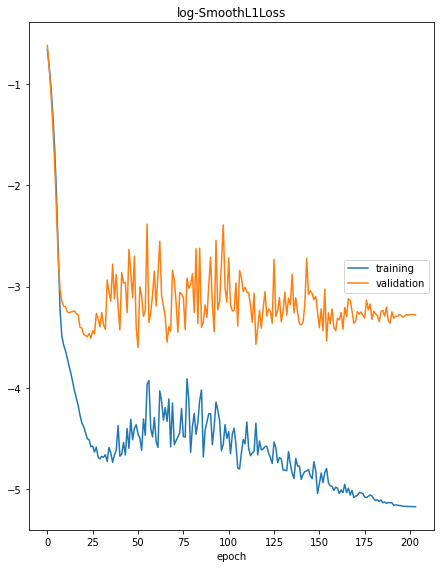

log-SmoothL1Loss
	training         	 (min:   -5.177, max:   -0.660, cur:   -5.177)
	validation       	 (min:   -3.603, max:   -0.616, cur:   -3.280)


In [40]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    # "seasonality_mode": "additive", 
    # "learning_rate": 0.1,
    # "n_changepoints": 40, # 48
    # "changepoints_range": 0.95, 
    # "trend_reg": 1,
    # "num_hidden_layers": 2,
    # "d_hidden": 64,
    # "yearly_seasonality": True, # True
    # "weekly_seasonality": False,
    # "daily_seasonality": False,
    # "loss_func": 'MSE',
    # "n_lags": 12,
    # "user_changepoints", 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

In [41]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
203,0.005646,0.197236,0.260652,0.0,0.03764,0.574341,0.695812


### Evaluation

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.038  0.574  0.696


   SmoothL1Loss       MAE      RMSE
0       0.03764  0.574341  0.695812


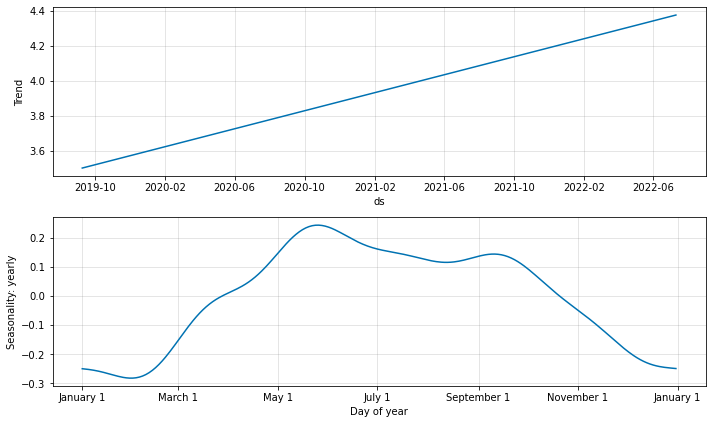

In [42]:
test_pred = model.predict(df_test)
test_components = model.plot_components(test_pred)

test_metrics = model.test(df_test)
print(test_metrics)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


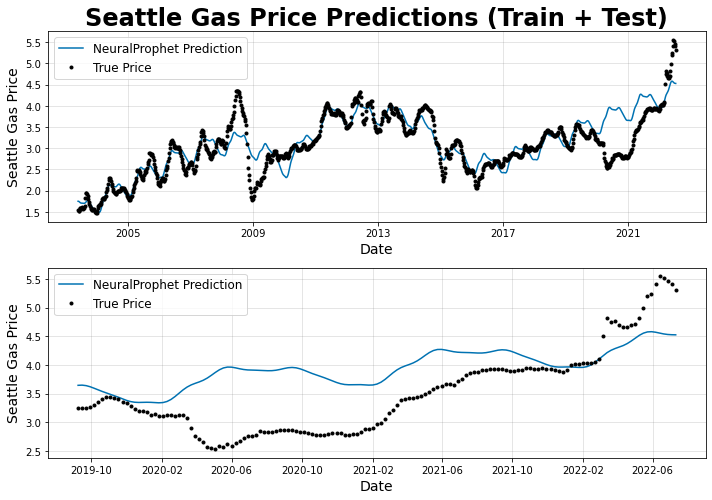

In [43]:
# fig, ax = plt.subplots(figsize=(10, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
model.plot(model.predict(df), ax=ax1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Seattle Gas Price', fontsize=14)
ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# fig, ax = plt.subplots(figsize=(10, 7))
model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Seattle Gas Price', fontsize=14)
ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

### Forecasting

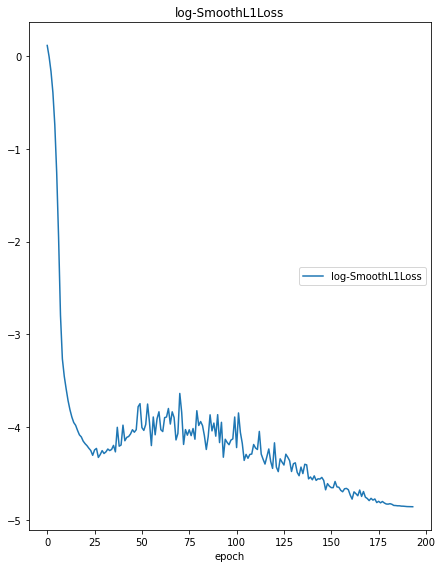

log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.856, max:    0.112, cur:   -4.856)


In [44]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W", progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


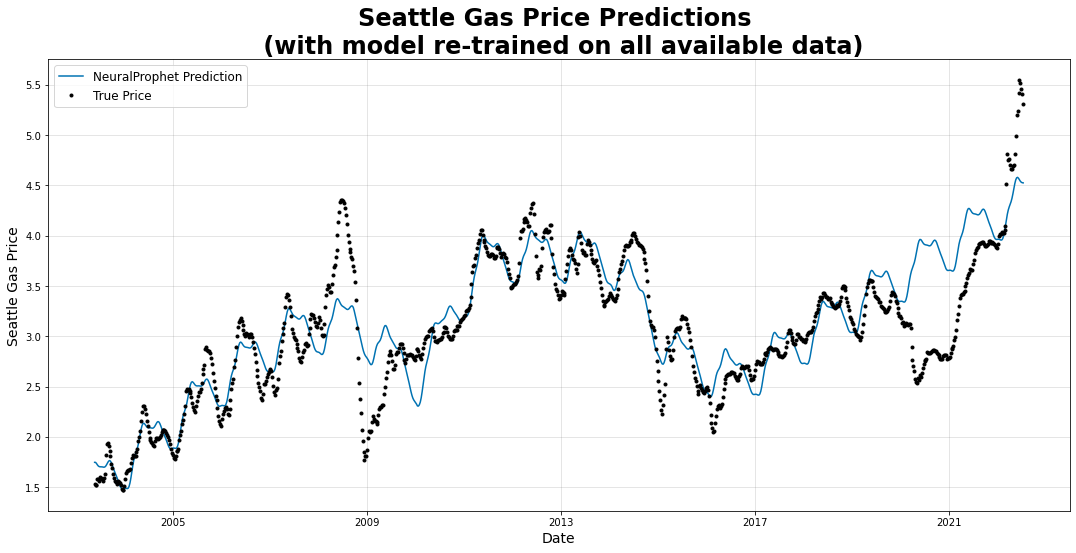

In [45]:
# fig = model.plot(model2.predict(df))
fig, ax = plt.subplots(figsize=(15, 7))
model.plot(model.predict(df), ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [46]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

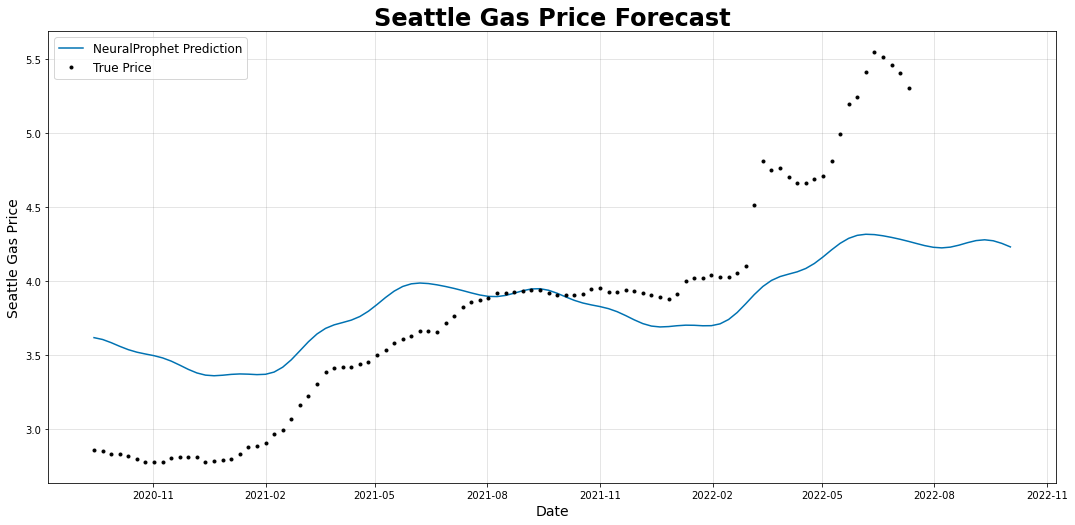

In [47]:
# fig = model2.plot(forecast)

fig, ax = plt.subplots(figsize=(15, 7))
model.plot(forecast, ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Forecast", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

## 6b. Neural Network (LSTM)

### Training

In [48]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=lstm_n_hidden, num_layers=lstm_n_layers, # hidden=64, layers=2
             seq_length=timesteps, device=device, dropout=0.2)
model_name = 'lstm'
lstm_opt = torch.optim.AdamW(lstm.parameters(), lr=0.01)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15)

Validation loss decreased (inf --> 0.008218).  Saving model ...
Iter:  0 train:  0.2747998719732186 val:  0.09065309142430626 LR:  0.01
mse:  0.05474461 mae:  0.19069424


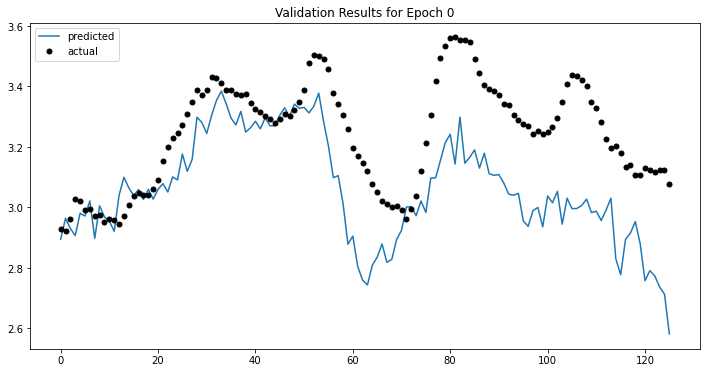

Validation loss decreased (0.008218 --> 0.006739).  Saving model ...
Iter:  1 train:  0.07572650267455198 val:  0.0820893590622516 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  2 train:  0.058788642161793865 val:  0.12115376375077505 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  3 train:  0.0557977146911742 val:  0.14467830829197847 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  4 train:  0.05661234121703094 val:  0.11274808909414667 LR:  0.01
Validation loss decreased (0.006739 --> 0.005039).  Saving model ...
Iter:  5 train:  0.05038174559438961 val:  0.07098586512056225 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  6 train:  0.04692540667536373 val:  0.10779669477207277 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  7 train:  0.05054992578049023 val:  0.09500134697848939 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  8 train:  0.04226378526429485 val:  0.09918153904703357 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  9 train:  0.048080491267961

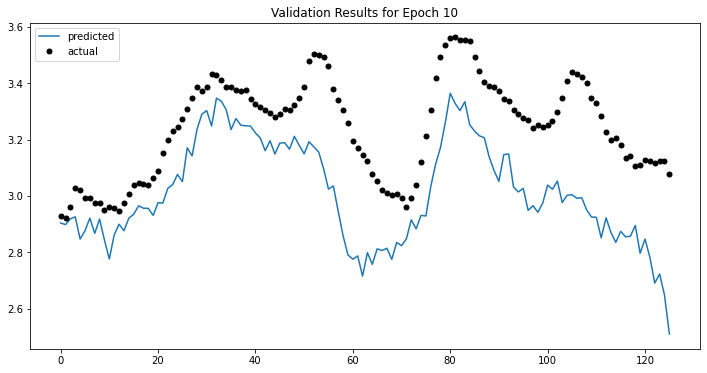

EarlyStopping counter: 6 out of 50
Iter:  11 train:  0.03744942529994621 val:  0.07851317672140241 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  12 train:  0.036803909438413884 val:  0.08557639529916866 LR:  0.01
Validation loss decreased (0.005039 --> 0.002067).  Saving model ...
Iter:  13 train:  0.043073065513541564 val:  0.045467682253271795 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.04477335704071425 val:  0.08922090464260546 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  15 train:  0.038057861586140114 val:  0.08211377581123487 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  16 train:  0.037461121793053456 val:  0.07208474671083802 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  17 train:  0.03715770492040776 val:  0.09004209449493202 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  18 train:  0.03946441944817255 val:  0.07572025435644755 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  19 train:  0.04038628133929519 val:  0.07546136

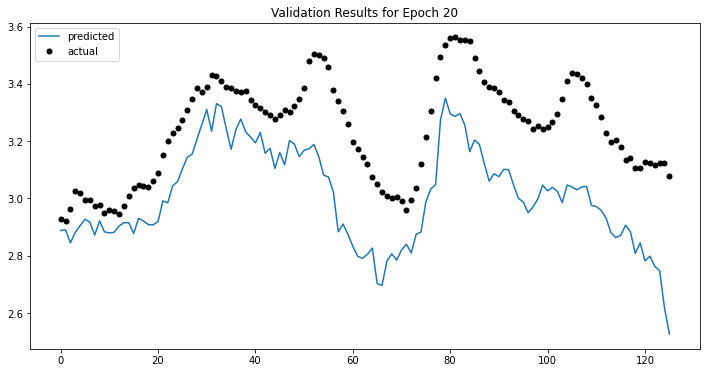

EarlyStopping counter: 8 out of 50
Iter:  21 train:  0.04292746409851036 val:  0.06274888513879323 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  22 train:  0.03930291569271311 val:  0.08196537911729476 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  23 train:  0.036844895087865884 val:  0.07745951036105259 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  24 train:  0.03260130035792933 val:  0.06392761871891933 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  25 train:  0.040605682850877824 val:  0.05979833759616892 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  26 train:  0.03668089238541683 val:  0.06631630152065382 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  27 train:  0.038732533599219826 val:  0.06690265521990542 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  28 train:  0.03534337313494496 val:  0.07490891338802404 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  29 train:  0.03841819343487778 val:  0.07369475654930158 LR:  0.001
EarlySto

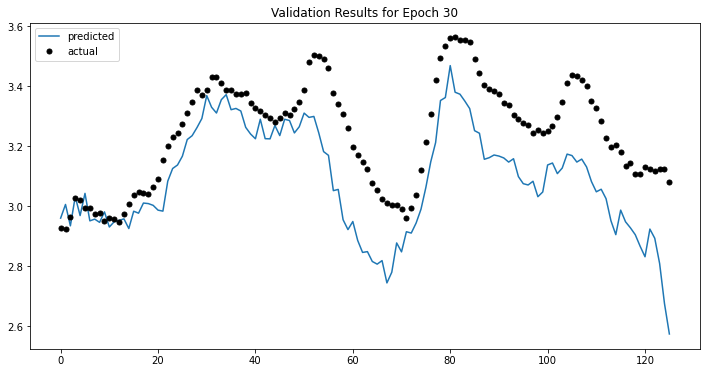

EarlyStopping counter: 18 out of 50
Iter:  31 train:  0.0279591285760256 val:  0.0742657064940482 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  32 train:  0.02703899133825323 val:  0.0776505799690045 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  33 train:  0.026940435937538452 val:  0.06806910097326609 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  34 train:  0.027007496215876184 val:  0.06921925356517669 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  35 train:  0.02742786079266379 val:  0.07731099826624434 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  36 train:  0.02709330405317355 val:  0.08173898608717356 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  37 train:  0.025944386113011017 val:  0.07782625515506571 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  38 train:  0.026317373946166366 val:  0.07110996188282363 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  39 train:  0.025756564924235278 val:  0.07221162495565159 LR:  0.001

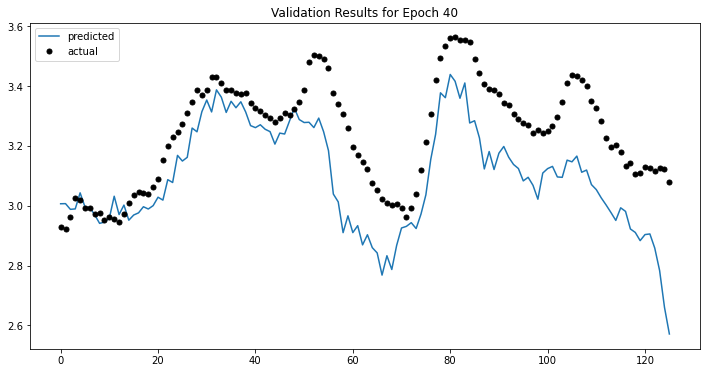

EarlyStopping counter: 28 out of 50
Iter:  41 train:  0.026411984146382683 val:  0.07758084024058483 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  42 train:  0.025712311826295818 val:  0.07215358835558999 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  43 train:  0.025214349707163644 val:  0.06979613311451346 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  44 train:  0.024362388241745542 val:  0.07118280817108197 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  45 train:  0.024498515048674986 val:  0.07606260853826496 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  46 train:  0.0246616513011936 val:  0.06908905726029385 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  47 train:  0.02442537845635204 val:  0.06893238804317198 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  48 train:  0.024001830276593125 val:  0.06821789932584349 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  49 train:  0.024846037152258752 val:  0.06929343079618147 LR

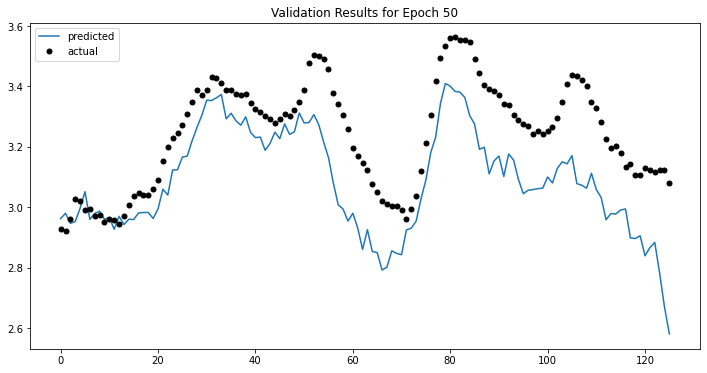

EarlyStopping counter: 38 out of 50
Iter:  51 train:  0.024451302617806654 val:  0.07151543876737153 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  52 train:  0.023631640169904423 val:  0.06842057334869962 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  53 train:  0.024093449705884618 val:  0.06810612610034568 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  54 train:  0.02340456659156502 val:  0.06678069953773193 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  55 train:  0.023866560558057703 val:  0.0708240671314746 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  56 train:  0.0240185520259472 val:  0.07042498721576412 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  57 train:  0.023500149007723386 val:  0.06897424784063688 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  58 train:  0.024339941000477833 val:  0.06895165633366761 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  59 train:  0.022796040511432816 val:  0.07104377140143013

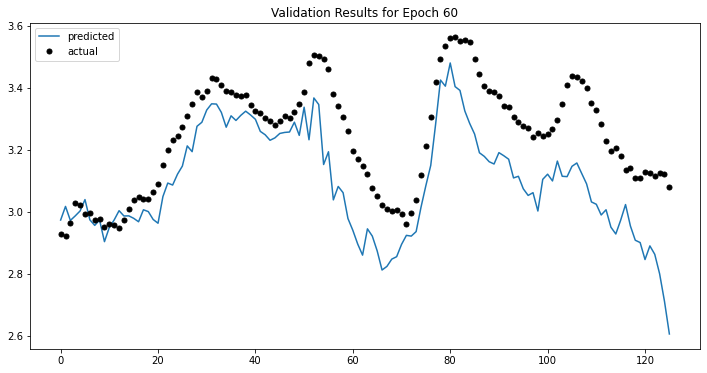

EarlyStopping counter: 48 out of 50
Iter:  61 train:  0.023040860547745814 val:  0.0689453249017531 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  62 train:  0.02417131297309896 val:  0.06936750867448917 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [49]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [50]:
lstm.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

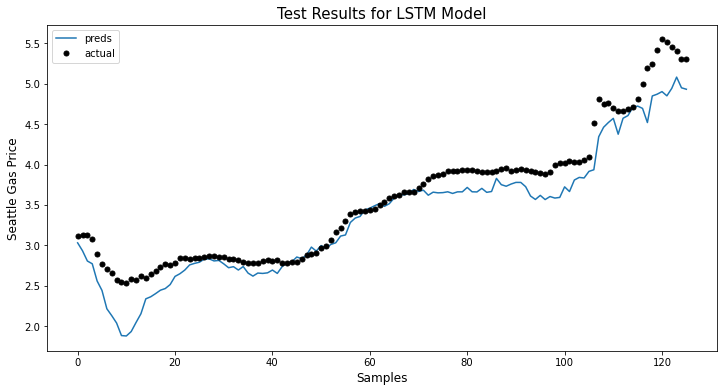

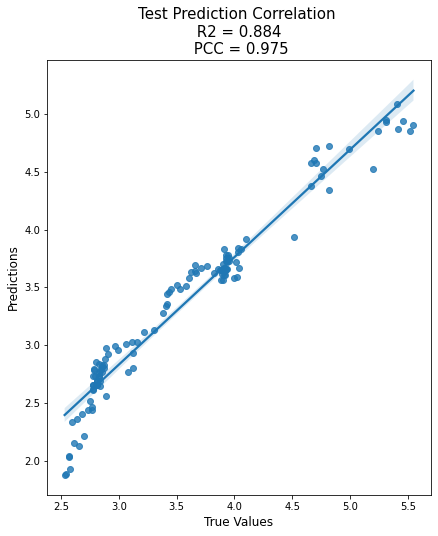

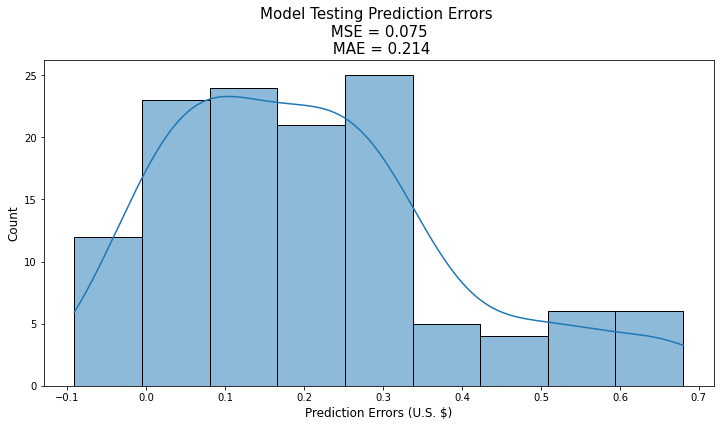

In [51]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true, _, _ = nn_eval(model=lstm, 
                                                                             model_name='lstm', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

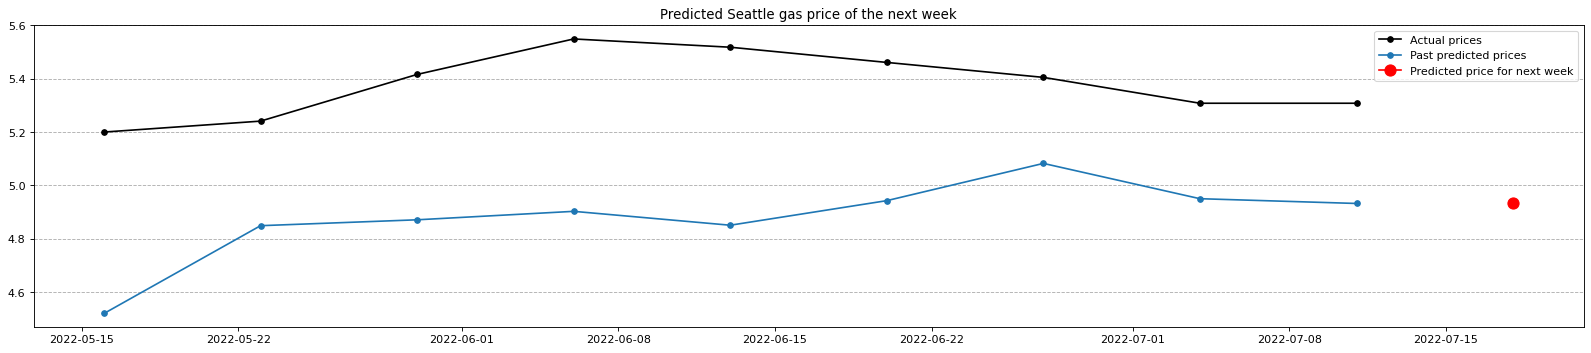

LSTM Predicted Seattle Gas Price of the next week: $4.93


In [52]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6c. Dual-Stage Attention-Based Recurrent Neural Network (DA-RNN)

### Training

In [53]:
darnn = DARNN(N=X_train.shape[2], M=darnn_n_enc_units, P=darnn_n_dec_units, # 1) M=64, P=16
              T=X_train.shape[1], device=device).to(device) 
model_name = 'darnn'
darnn_opt = torch.optim.AdamW(darnn.parameters(), lr=0.01)
darnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=darnn_opt, patience=15)

Validation loss decreased (inf --> 0.011915).  Saving model ...
Iter:  0 train:  0.2363669532272546 val:  0.10915584384208916 LR:  0.01
mse:  0.07937249 mae:  0.2506048


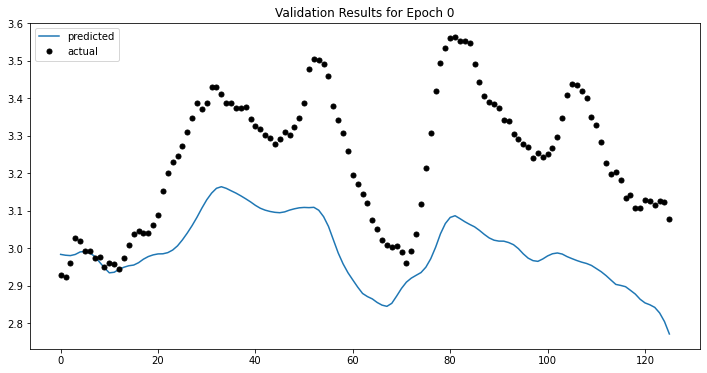

Validation loss decreased (0.011915 --> 0.011067).  Saving model ...
Iter:  1 train:  0.08674596713895315 val:  0.10520040364116184 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  2 train:  0.053195252332639685 val:  0.11488090977090308 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  3 train:  0.04328136052222757 val:  0.10892898121710066 LR:  0.01
Validation loss decreased (0.011067 --> 0.009645).  Saving model ...
Iter:  4 train:  0.04506546963726125 val:  0.09820959759602256 LR:  0.01
Validation loss decreased (0.009645 --> 0.003899).  Saving model ...
Iter:  5 train:  0.03598444300944268 val:  0.062443080916120684 LR:  0.01
Validation loss decreased (0.003899 --> 0.002823).  Saving model ...
Iter:  6 train:  0.029290167227060918 val:  0.05313524699388349 LR:  0.01
Validation loss decreased (0.002823 --> 0.001808).  Saving model ...
Iter:  7 train:  0.024314922166624172 val:  0.04252512218685161 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  8 train:  0.0206232411344605

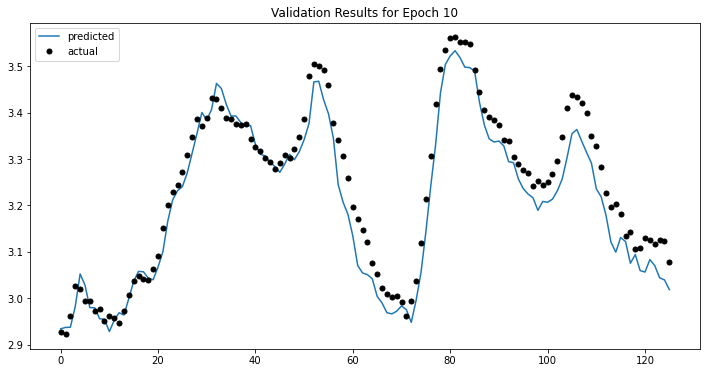

EarlyStopping counter: 1 out of 50
Iter:  11 train:  0.019939379788138874 val:  0.04136567037370429 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  12 train:  0.02054667131577277 val:  0.03315982897519267 LR:  0.01
Validation loss decreased (0.000351 --> 0.000145).  Saving model ...
Iter:  13 train:  0.017549329224599692 val:  0.012042897297534867 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.01959295155335919 val:  0.030041915824447138 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  15 train:  0.017565828986329635 val:  0.023761814401587752 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  16 train:  0.015434876659412464 val:  0.02419724268923344 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  17 train:  0.0217069063094771 val:  0.041099518677046726 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  18 train:  0.01856106588131502 val:  0.021103689638445642 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  19 train:  0.016265424222828413 val:  0.0303

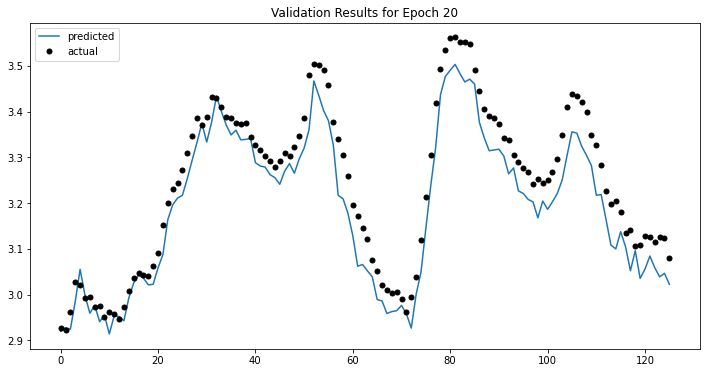

EarlyStopping counter: 8 out of 50
Iter:  21 train:  0.017545198247338512 val:  0.01745228532713614 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  22 train:  0.019573706476079956 val:  0.012941240551803172 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  23 train:  0.021454115336534515 val:  0.015586590268067642 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  24 train:  0.016281046862547565 val:  0.014928177401629465 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  25 train:  0.018238560670216477 val:  0.026100221702341848 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  26 train:  0.017223297031779213 val:  0.037261394448144386 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  27 train:  0.021784802805294844 val:  0.026264679441796 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  28 train:  0.020112787495695988 val:  0.024584069912102803 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  29 train:  0.018429814326168824 val:  0.025535965322977566 LR:  0.0

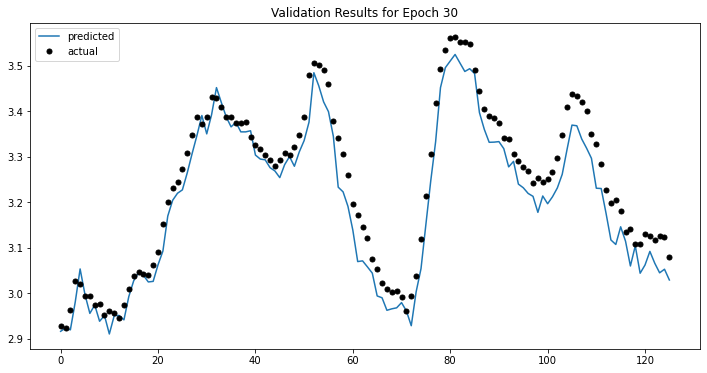

EarlyStopping counter: 18 out of 50
Iter:  31 train:  0.014658970687063637 val:  0.01839976053736439 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  32 train:  0.014276262810791772 val:  0.020640571304164548 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  33 train:  0.014368290522857397 val:  0.01984299740676361 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  34 train:  0.014240353418544283 val:  0.01741571147785 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  35 train:  0.014563446695972584 val:  0.02231890576279594 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  36 train:  0.01430818773110486 val:  0.021799466042786705 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  37 train:  0.014482050166123422 val:  0.017145142837481846 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  38 train:  0.014092726033481592 val:  0.02156936046852168 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  39 train:  0.014249571542847143 val:  0.01983067607341768 LR: 

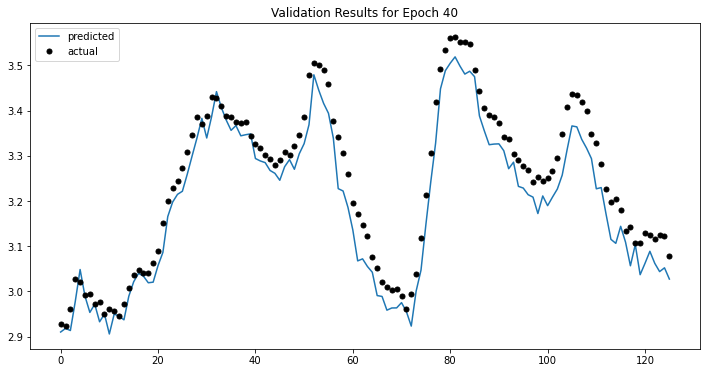

EarlyStopping counter: 28 out of 50
Iter:  41 train:  0.014170986279444839 val:  0.01881453102131878 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  42 train:  0.014391776502765932 val:  0.01631962799800173 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  43 train:  0.014428277989407783 val:  0.016975669743082733 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  44 train:  0.014339482361968931 val:  0.022037830063894367 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  45 train:  0.014462179178244116 val:  0.018879766994440286 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  46 train:  0.013801781016414261 val:  0.021316689730577505 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  47 train:  0.013802235643261692 val:  0.01980104735932537 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  48 train:  0.01381594375047417 val:  0.019486960981281554 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  49 train:  0.013889930799242996 val:  0.0210229603238

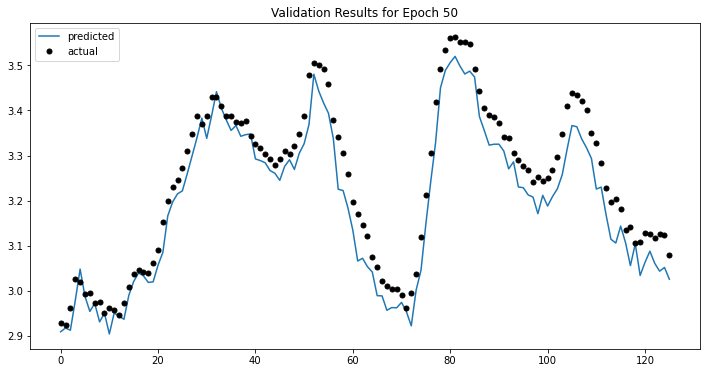

EarlyStopping counter: 38 out of 50
Iter:  51 train:  0.013838423954070462 val:  0.02021518221799895 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  52 train:  0.013781953145576073 val:  0.021014734380287264 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  53 train:  0.01379780690961761 val:  0.020954264276069706 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  54 train:  0.01380523905414107 val:  0.019015673233862013 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  55 train:  0.013801878749154138 val:  0.020353903411765774 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  56 train:  0.013770189348710665 val:  0.018177831259235028 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  57 train:  0.013853784876119662 val:  0.0206195018826873 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  58 train:  0.01378521346333507 val:  0.02067556980569323 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  59 train:  0.013795082489466998 val:  0.019186154965

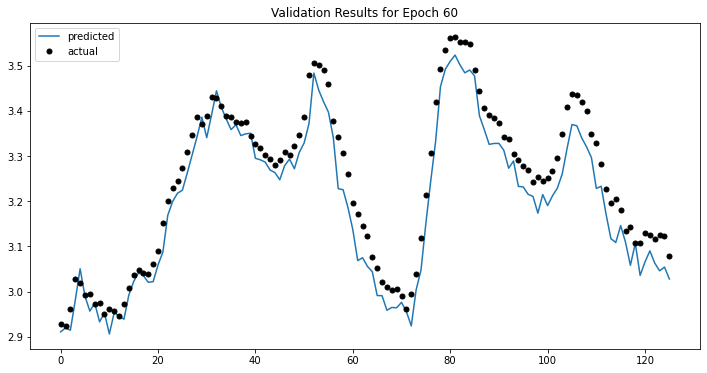

EarlyStopping counter: 48 out of 50
Iter:  61 train:  0.013804693480230272 val:  0.01995610692738028 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  62 train:  0.013754406829979459 val:  0.02013251384934134 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [54]:
nn_train(model=darnn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=darnn_opt, 
         scheduler=darnn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [55]:
darnn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

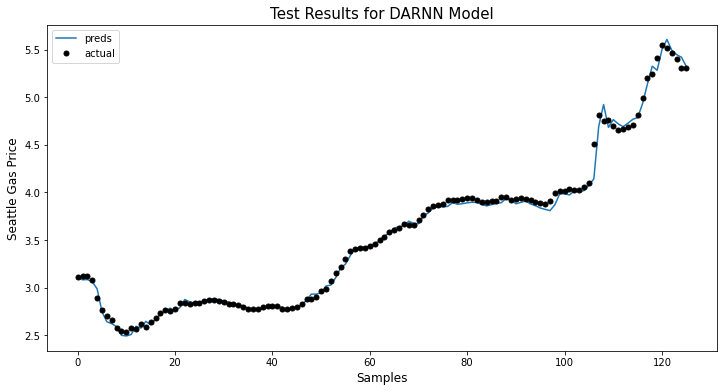

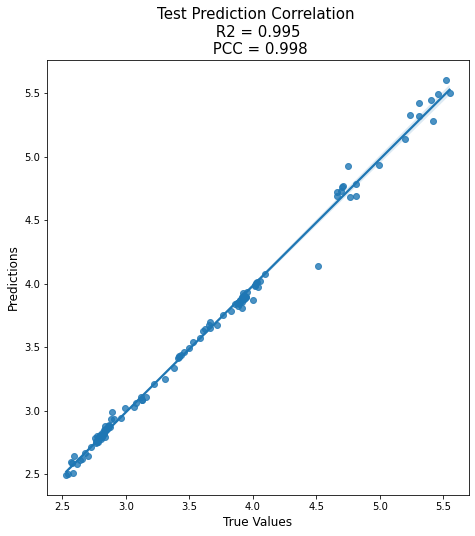

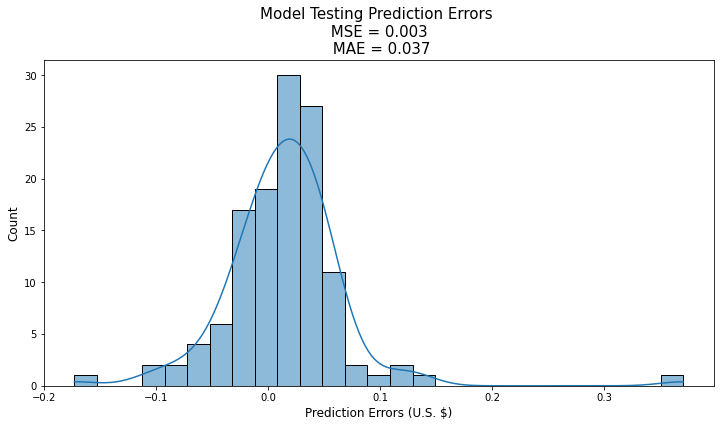

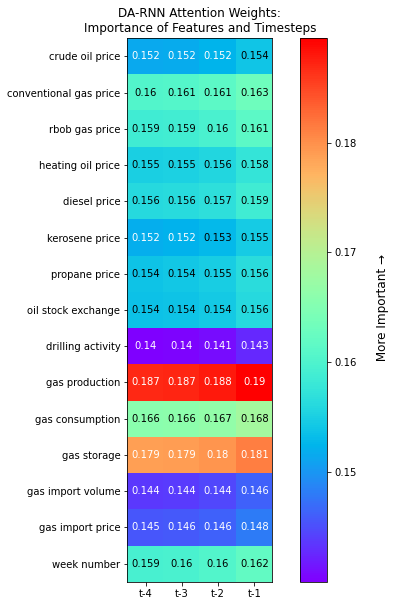

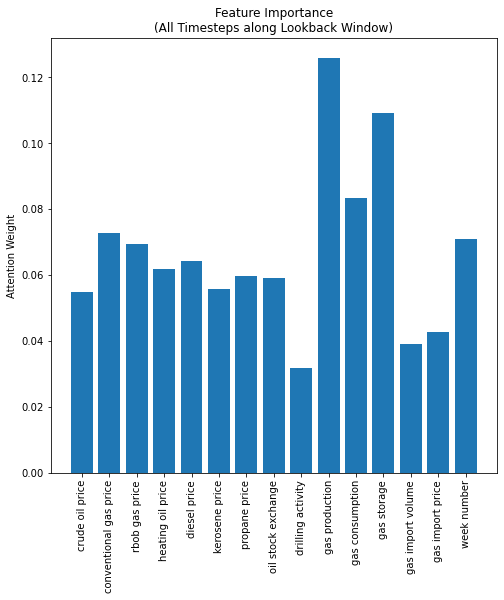

In [75]:
darnn_mse, darnn_mae, darnn_r2, darnn_pcc, darnn_preds, darnn_true, darnn_alphas, darnn_betas = nn_eval(model=darnn, 
                                                                             model_name='darnn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

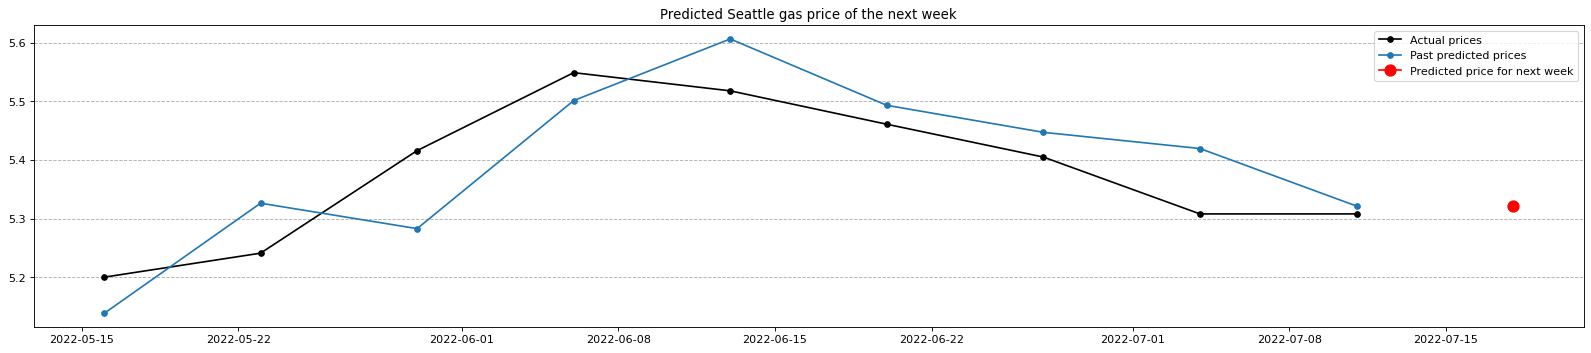

DARNN Predicted Seattle Gas Price of the next week: $5.32


In [57]:
nn_forecast(model = darnn,
            model_name = 'darnn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = darnn_true, 
            preds = darnn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6d. Hierarchical Attention-Based Recurrent Highway Network (HARHN)

### Training

In [78]:
harhn = HARHN(n_conv_layers=3, 
              T=timesteps, 
              in_feats=n_timeseries, 
              target_feats=1, 
              n_units_enc=harhn_n_enc_units, 
              n_units_dec=harhn_n_dec_units, 
              device=device
             ).to(device)
model_name = 'harhn'
harhn_opt = torch.optim.AdamW(harhn.parameters(), lr=0.01)
harhn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=harhn_opt, patience=15)

Validation loss decreased (inf --> 0.000370).  Saving model ...
Iter:  0 train:  0.17200133999292458 val:  0.0192323799537935 LR:  0.01
mse:  0.0024640071 mae:  0.03935674


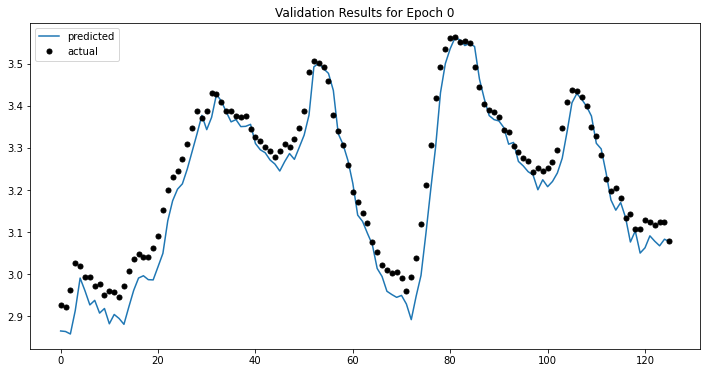

Validation loss decreased (0.000370 --> 0.000113).  Saving model ...
Iter:  1 train:  0.024158359615651766 val:  0.010629124619941609 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  2 train:  0.01994058628309877 val:  0.01264636388277997 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  3 train:  0.01935544966640753 val:  0.0122847822570567 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  4 train:  0.019569131102041153 val:  0.014284727159120172 LR:  0.01
Validation loss decreased (0.000113 --> 0.000107).  Saving model ...
Iter:  5 train:  0.0180702637192467 val:  0.010331427806718828 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  6 train:  0.018852421085065168 val:  0.019722221489977383 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  7 train:  0.019113147754210358 val:  0.014502661171458037 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  8 train:  0.01817675406320049 val:  0.013739276004285487 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  9 train:  0.020402

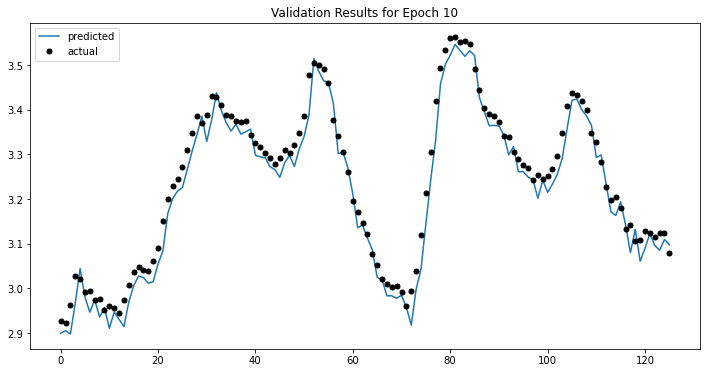

EarlyStopping counter: 6 out of 50
Iter:  11 train:  0.02191933648189455 val:  0.019450669467909215 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  12 train:  0.021655835068942603 val:  0.02385579153625851 LR:  0.01
Validation loss decreased (0.000107 --> 0.000103).  Saving model ...
Iter:  13 train:  0.023724744382496266 val:  0.010166184537723317 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.017887215490512913 val:  0.01300613251622691 LR:  0.01
Validation loss decreased (0.000103 --> 0.000092).  Saving model ...
Iter:  15 train:  0.019798270301518883 val:  0.009592775141647024 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  16 train:  0.01809774377422886 val:  0.019761457700925158 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  17 train:  0.02140005096937665 val:  0.018421672761140657 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  18 train:  0.02506601148641929 val:  0.017114904104515213 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  19 train

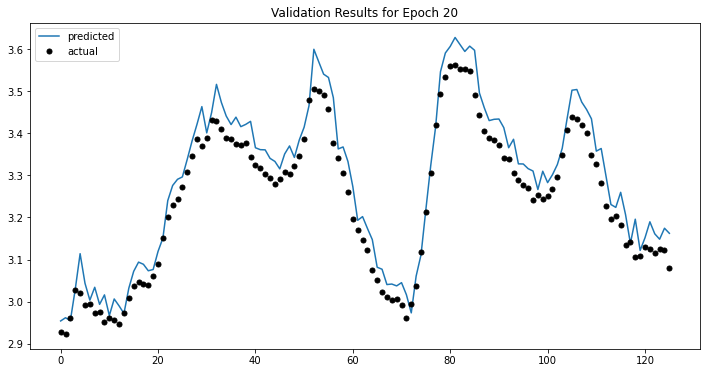

EarlyStopping counter: 6 out of 50
Iter:  21 train:  0.024493845017552654 val:  0.019917620173215196 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  22 train:  0.019397362125220346 val:  0.01249197785959981 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  23 train:  0.018290836815875375 val:  0.01500611991281142 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  24 train:  0.020706275889257098 val:  0.01792093070645255 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  25 train:  0.023116231052417408 val:  0.02114848926224012 LR:  0.01
Validation loss decreased (0.000092 --> 0.000088).  Saving model ...
Iter:  26 train:  0.021965944382716943 val:  0.009364241882176211 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  27 train:  0.018066539618296552 val:  0.010516310647809975 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  28 train:  0.018269376192570595 val:  0.013366901623307063 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  29 train:  0.017115841936191506 val:  0

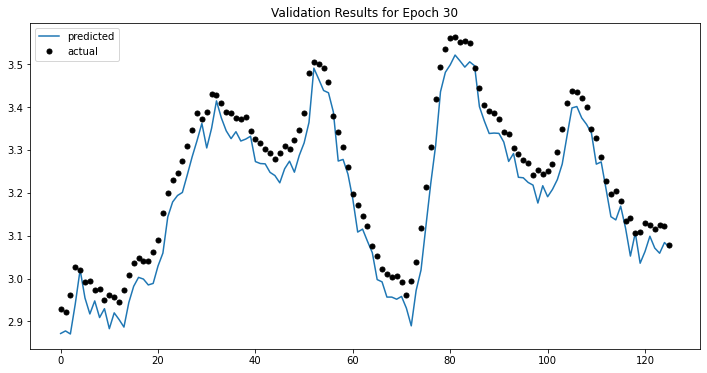

EarlyStopping counter: 5 out of 50
Iter:  31 train:  0.023904692766969295 val:  0.011367458051116011 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  32 train:  0.022294035773061823 val:  0.015860699890827192 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  33 train:  0.019164043546784054 val:  0.02165760104588905 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  34 train:  0.019238563500784633 val:  0.01521296758584768 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  35 train:  0.021875406460322763 val:  0.014451856789698105 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  36 train:  0.017511507649017852 val:  0.011269356758302035 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  37 train:  0.021343798121215098 val:  0.010145157816848698 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  38 train:  0.018406244872607308 val:  0.011403768556294748 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  39 train:  0.019848629293606104 val:  0.023601416826103637 LR:  0.01

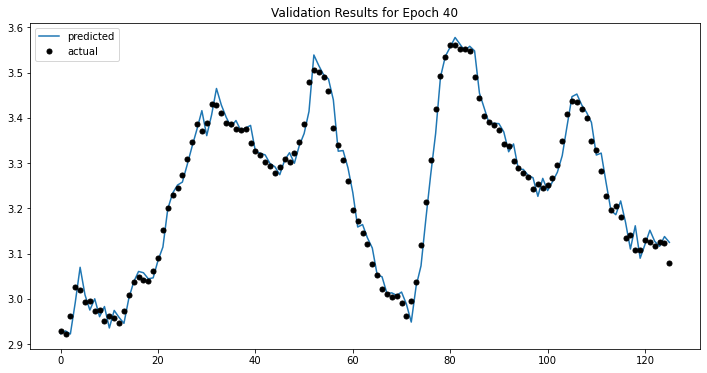

EarlyStopping counter: 15 out of 50
Iter:  41 train:  0.019321734082790074 val:  0.009986900893808335 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  42 train:  0.019392019604998995 val:  0.01910972159018527 LR:  0.001
Validation loss decreased (0.000088 --> 0.000087).  Saving model ...
Iter:  43 train:  0.017952317297333136 val:  0.00933367198308328 LR:  0.001
Validation loss decreased (0.000087 --> 0.000083).  Saving model ...
Iter:  44 train:  0.016126141585599617 val:  0.009127159732798436 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  45 train:  0.015276645788838764 val:  0.009362434925988854 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  46 train:  0.015015442395516996 val:  0.009454890455084205 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  47 train:  0.01548394570720753 val:  0.009372675693954249 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  48 train:  0.015941445447024093 val:  0.01114911005691306 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter

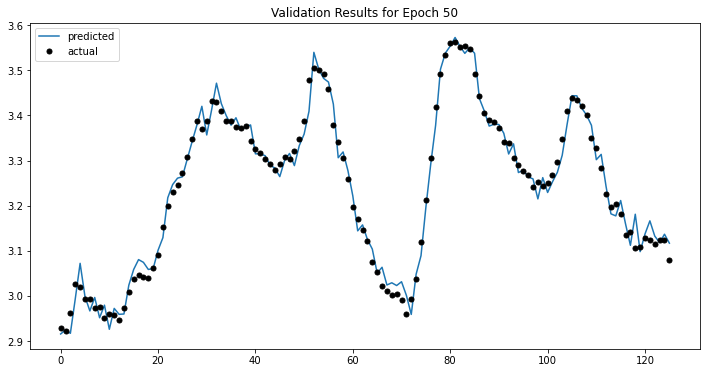

EarlyStopping counter: 7 out of 50
Iter:  51 train:  0.01507002608721091 val:  0.00957875300197303 LR:  0.001
EarlyStopping counter: 8 out of 50
Iter:  52 train:  0.01512900351379581 val:  0.010304083985425592 LR:  0.001
EarlyStopping counter: 9 out of 50
Iter:  53 train:  0.01552419358227401 val:  0.010402611087621541 LR:  0.001
EarlyStopping counter: 10 out of 50
Iter:  54 train:  0.015227203764929888 val:  0.009918148438799696 LR:  0.001
EarlyStopping counter: 11 out of 50
Iter:  55 train:  0.015411184967205142 val:  0.009944703423519512 LR:  0.001
EarlyStopping counter: 12 out of 50
Iter:  56 train:  0.015038210915753728 val:  0.009807195142981156 LR:  0.001
EarlyStopping counter: 13 out of 50
Iter:  57 train:  0.015066906901769567 val:  0.010615285926534412 LR:  0.001
EarlyStopping counter: 14 out of 50
Iter:  58 train:  0.015250504691554388 val:  0.010063550246411783 LR:  0.001
EarlyStopping counter: 15 out of 50
Iter:  59 train:  0.015025396907922692 val:  0.011896444795937131 L

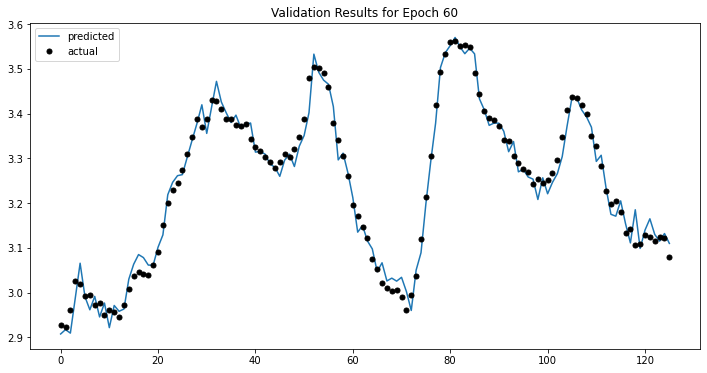

EarlyStopping counter: 17 out of 50
Iter:  61 train:  0.014765866283381165 val:  0.009970886364431117 LR:  0.0001
EarlyStopping counter: 18 out of 50
Iter:  62 train:  0.014712105922262384 val:  0.009969574241100659 LR:  0.0001
EarlyStopping counter: 19 out of 50
Iter:  63 train:  0.014662985619583829 val:  0.010038861563188462 LR:  0.0001
EarlyStopping counter: 20 out of 50
Iter:  64 train:  0.014746224635501824 val:  0.0099445868363456 LR:  0.0001
EarlyStopping counter: 21 out of 50
Iter:  65 train:  0.014815630153772012 val:  0.010216633099445677 LR:  0.0001
EarlyStopping counter: 22 out of 50
Iter:  66 train:  0.014774384239094529 val:  0.01002333565932018 LR:  0.0001
EarlyStopping counter: 23 out of 50
Iter:  67 train:  0.014689705423680003 val:  0.009957101941909645 LR:  0.0001
EarlyStopping counter: 24 out of 50
Iter:  68 train:  0.014762349908481466 val:  0.009986166950913188 LR:  0.0001
EarlyStopping counter: 25 out of 50
Iter:  69 train:  0.014705230764204064 val:  0.00998455

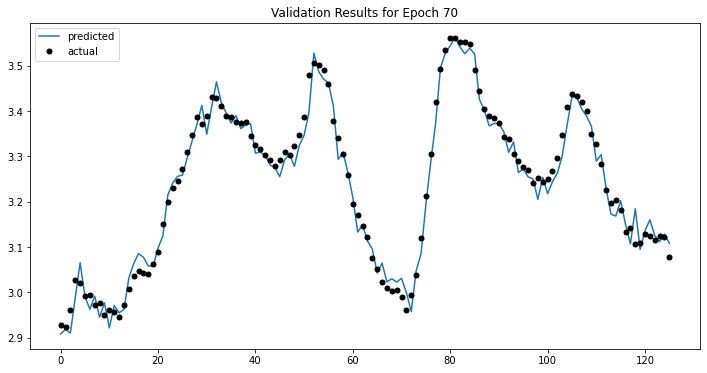

EarlyStopping counter: 27 out of 50
Iter:  71 train:  0.014687777189982322 val:  0.010029702619057742 LR:  0.0001
EarlyStopping counter: 28 out of 50
Iter:  72 train:  0.014763583214780406 val:  0.009964434638962768 LR:  0.0001
EarlyStopping counter: 29 out of 50
Iter:  73 train:  0.01468075489518857 val:  0.009983442561568006 LR:  0.0001
EarlyStopping counter: 30 out of 50
Iter:  74 train:  0.014699723713327789 val:  0.010089453379577262 LR:  0.0001
EarlyStopping counter: 31 out of 50
Iter:  75 train:  0.014692373706440272 val:  0.010088806514780068 LR:  0.0001
EarlyStopping counter: 32 out of 50
Iter:  76 train:  0.014627930506096374 val:  0.010119930503746224 LR:  1e-05
EarlyStopping counter: 33 out of 50
Iter:  77 train:  0.014677402564259869 val:  0.010032924142179545 LR:  1e-05
EarlyStopping counter: 34 out of 50
Iter:  78 train:  0.014636976186901606 val:  0.010002917528637571 LR:  1e-05
EarlyStopping counter: 35 out of 50
Iter:  79 train:  0.014626892686798967 val:  0.009999543

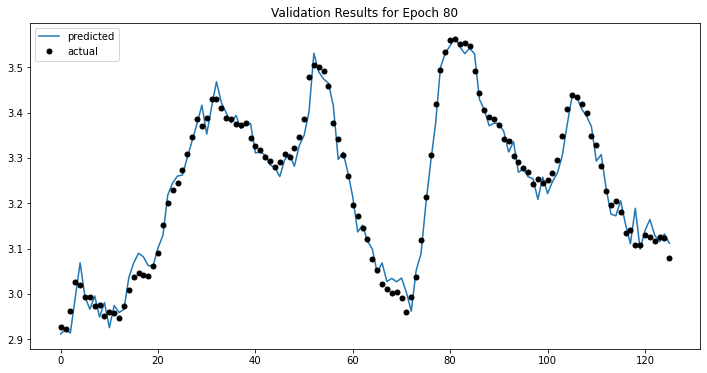

EarlyStopping counter: 37 out of 50
Iter:  81 train:  0.014625918733741777 val:  0.010004382949044573 LR:  1e-05
EarlyStopping counter: 38 out of 50
Iter:  82 train:  0.01462813800756772 val:  0.010007097471181788 LR:  1e-05
EarlyStopping counter: 39 out of 50
Iter:  83 train:  0.014626772799753591 val:  0.01000561939361068 LR:  1e-05
EarlyStopping counter: 40 out of 50
Iter:  84 train:  0.014630520797384276 val:  0.010009188103251637 LR:  1e-05
EarlyStopping counter: 41 out of 50
Iter:  85 train:  0.014619430186589165 val:  0.010013163551428656 LR:  1e-05
EarlyStopping counter: 42 out of 50
Iter:  86 train:  0.014620621644007611 val:  0.010014269804338503 LR:  1e-05
EarlyStopping counter: 43 out of 50
Iter:  87 train:  0.014619536152825529 val:  0.010011073495759434 LR:  1e-05
EarlyStopping counter: 44 out of 50
Iter:  88 train:  0.014620645164962403 val:  0.010015038854783807 LR:  1e-05
EarlyStopping counter: 45 out of 50
Iter:  89 train:  0.014624425692910722 val:  0.010010732071236

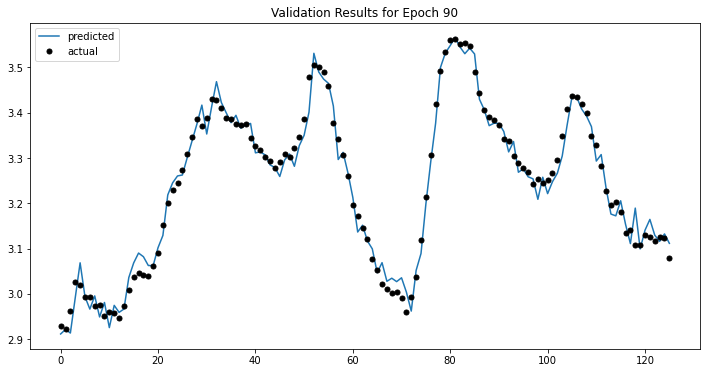

EarlyStopping counter: 47 out of 50
Iter:  91 train:  0.014627749915961956 val:  0.010013150333506027 LR:  1e-05
EarlyStopping counter: 48 out of 50
Iter:  92 train:  0.01461765757708781 val:  0.01001919483611712 LR:  1.0000000000000002e-06
EarlyStopping counter: 49 out of 50
Iter:  93 train:  0.014613547514763096 val:  0.010018840454884353 LR:  1.0000000000000002e-06
EarlyStopping counter: 50 out of 50
Early stopping


In [59]:
nn_train(model=harhn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=harhn_opt, 
         scheduler=harhn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [95]:
harhn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

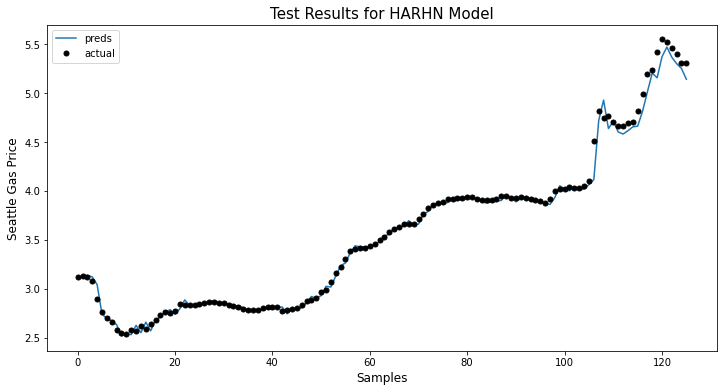

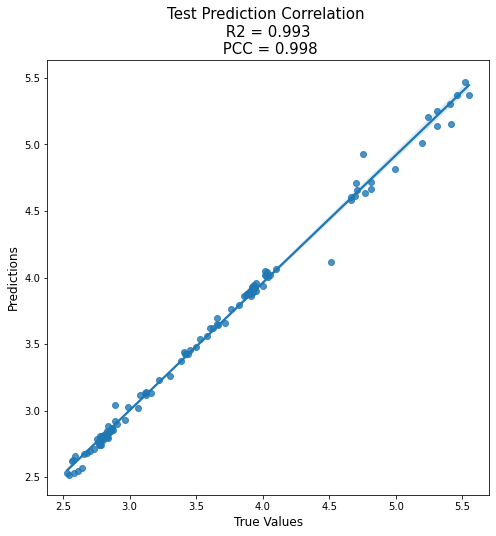

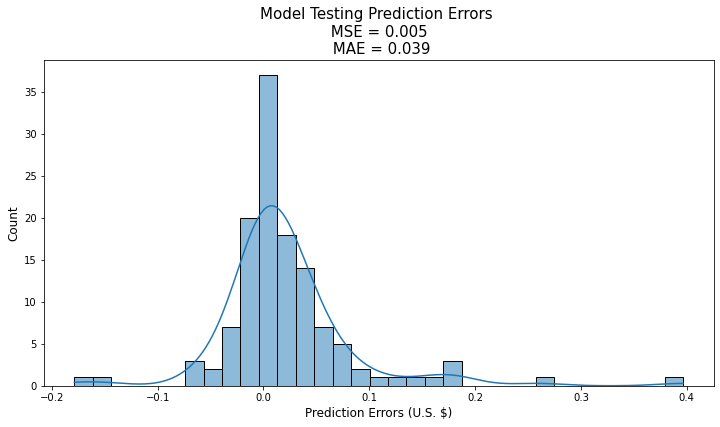

In [96]:
harhn_mse, harhn_mae, harhn_r2, harhn_pcc, harhn_preds, harhn_true, _, _ = nn_eval(model=harhn, 
                                                                             model_name='harhn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecast

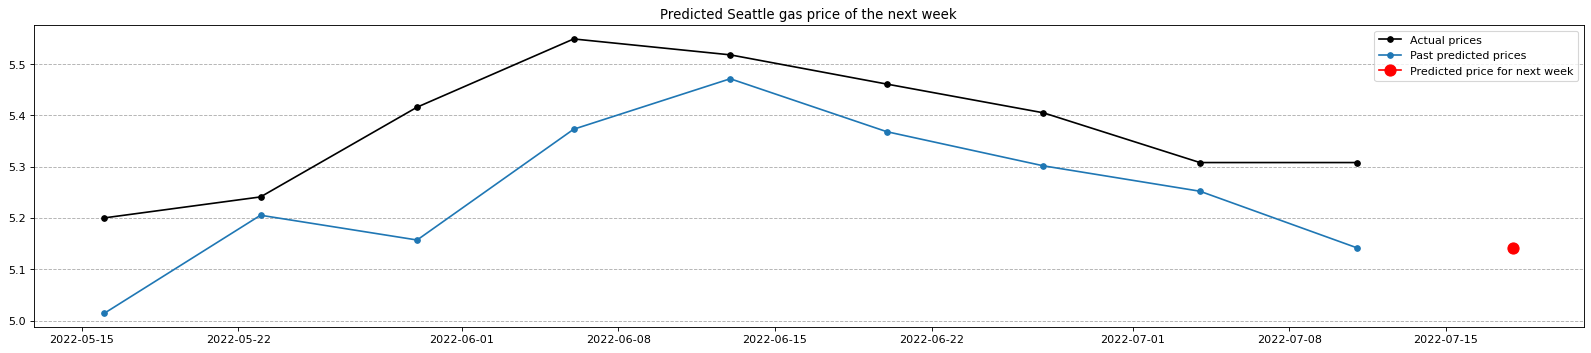

HARHN Predicted Seattle Gas Price of the next week: $5.14


In [65]:
nn_forecast(model = harhn,
            model_name = 'harhn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = harhn_true, 
            preds = harhn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

# 8. Model Comparison